In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report


In [2]:
df = pd.read_csv("../datasets/target_molecules_clean.csv")
df.head()

,pIC50,ECFP4_0,ECFP4_1,ECFP4_2,ECFP4_3,ECFP4_4,ECFP4_5,ECFP4_6,ECFP4_7,ECFP4_8,...,ECFP4_2038,ECFP4_2039,ECFP4_2040,ECFP4_2041,ECFP4_2042,ECFP4_2043,ECFP4_2044,ECFP4_2045,ECFP4_2046,ECFP4_2047
0,-0.301030,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,-0.301030,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,-0.301030,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3.531653,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,4.337242,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
threshold = 5.0
df['activity_class'] = (df['pIC50'] >= threshold).astype(int)

# Check the class distribution
class_distribution = df['activity_class'].value_counts(normalize=True) * 100

class_distribution

activity_class
0    71.318822
1    28.681178
Name: proportion, dtype: float64

In [7]:
df.drop(columns=['pIC50'], inplace=True)
df.head()

,ECFP4_0,ECFP4_1,ECFP4_2,ECFP4_3,ECFP4_4,ECFP4_5,ECFP4_6,ECFP4_7,ECFP4_8,ECFP4_9,...,ECFP4_2039,ECFP4_2040,ECFP4_2041,ECFP4_2042,ECFP4_2043,ECFP4_2044,ECFP4_2045,ECFP4_2046,ECFP4_2047,activity_class
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
X = df.copy()
X.drop(columns=['activity_class'], inplace=True)
y = df['activity_class'].copy()
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, test_size=0.2,random_state=42 )


In [22]:
class_distribution = y_train.value_counts(normalize=True) * 100
class_distribution

activity_class
0    70.456365
1    29.543635
Name: proportion, dtype: float64

In [21]:
class_distribution = y_val.value_counts(normalize=True) * 100
class_distribution

activity_class
0    74.760383
1    25.239617
Name: proportion, dtype: float64

In [24]:
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, test_size=0.2,random_state=42, stratify=df['activity_class'] )


In [25]:
class_distribution = y_train.value_counts(normalize=True) * 100
class_distribution

activity_class
0    71.33707
1    28.66293
Name: proportion, dtype: float64

In [26]:
class_distribution = y_val.value_counts(normalize=True) * 100
class_distribution

activity_class
0    71.246006
1    28.753994
Name: proportion, dtype: float64

In [32]:
# Compute class weights to handle class imbalance
from sklearn.utils.class_weight import compute_class_weight
import xgboost as xgb

xgb_classifier_weighted = xgb.XGBClassifier(random_state=42)

# Train the classifier
xgb_classifier_weighted.fit(X_train, y_train)

# Predict on the validation set
y_pred_class_xgb_weighted = xgb_classifier_weighted.predict(X_val)

# Calculate performance metrics
accuracy_xgb_weighted = accuracy_score(y_val, y_pred_class_xgb_weighted)
classification_rep_xgb_weighted = classification_report(y_val, y_pred_class_xgb_weighted)

# Convert the classification report to a dictionary
report_dict_xgb_weighted = classification_report(y_val, y_pred_class_xgb_weighted, output_dict=True)

# Convert the dictionary to a pandas DataFrame
report_df_xgb_weighted = pd.DataFrame(report_dict_xgb_weighted).transpose()

accuracy_xgb_weighted, report_df_xgb_weighted

(0.8722044728434505,
               precision    recall  f1-score     support
 0              0.879668  0.950673  0.913793  223.000000
 1              0.847222  0.677778  0.753086   90.000000
 accuracy       0.872204  0.872204  0.872204    0.872204
 macro avg      0.863445  0.814225  0.833440  313.000000
 weighted avg   0.870339  0.872204  0.867584  313.000000)

In [28]:
class_weights = compute_class_weight('balanced', classes=[0, 1], y=y_train)
weights = {0: class_weights[0], 1: class_weights[1]}
weights

{0: 0.7008978675645342, 1: 1.744413407821229}

In [33]:
xgb_classifier_weighted = xgb.XGBClassifier(random_state=42, scale_pos_weight=weights[1])

# Train the classifier
xgb_classifier_weighted.fit(X_train, y_train)

# Predict on the validation set
y_pred_class_xgb_weighted = xgb_classifier_weighted.predict(X_val)

# Calculate performance metrics
accuracy_xgb_weighted = accuracy_score(y_val, y_pred_class_xgb_weighted)
classification_rep_xgb_weighted = classification_report(y_val, y_pred_class_xgb_weighted)

# Convert the classification report to a dictionary
report_dict_xgb_weighted = classification_report(y_val, y_pred_class_xgb_weighted, output_dict=True)

# Convert the dictionary to a pandas DataFrame
report_df_xgb_weighted = pd.DataFrame(report_dict_xgb_weighted).transpose()

accuracy_xgb_weighted, report_df_xgb_weighted

(0.865814696485623,
               precision    recall  f1-score     support
 0              0.888412  0.928251  0.907895  223.000000
 1              0.800000  0.711111  0.752941   90.000000
 accuracy       0.865815  0.865815  0.865815    0.865815
 macro avg      0.844206  0.819681  0.830418  313.000000
 weighted avg   0.862990  0.865815  0.863339  313.000000)

In [34]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'learning_rate': [0.01, 0.1, 0.5],
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7]
}

grid_search = GridSearchCV(estimator=xgb_classifier_weighted, param_grid=param_grid, 
                           cv=3, verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

best_parameters = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_parameters)
print("Best Score:", best_score)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best Parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 50}
Best Score: 0.8767236211031175


In [35]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

# Assuming you have already defined X_train, y_train, and xgb_classifier_weighted

param_grid = {
    'learning_rate': [0.01, 0.1, 0.5],
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7]
}

# Create RandomizedSearchCV object
random_search = RandomizedSearchCV(estimator=xgb_classifier_weighted, param_distributions=param_grid, 
                                   n_iter=10,  # Number of parameter settings to try (adjust as needed)
                                   cv=3, verbose=2, n_jobs=-1, random_state=42)

# Fit RandomizedSearchCV to the training data
random_search.fit(X_train, y_train)

# Retrieve the best parameters and score
best_parameters = random_search.best_params_
best_score = random_search.best_score_

print("Best Parameters:", best_parameters)
print("Best Score:", best_score)


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters: {'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.1}
Best Score: 0.8751191354608622


In [44]:
from sklearn.model_selection import KFold

# Initialize XGBoost classifier
xgb_classifier = xgb.XGBClassifier()

# Number of folds
n_splits = 10

# Initialize KFold
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Store the scores
scores = []

# Loop over each fold
for train_index, test_index in kf.split(X):
    X_train_fold, X_val_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[test_index]

    # Fit the model on the training data
    xgb_classifier.fit(X_train_fold, y_train_fold)

    # Predict on the validation data
    y_pred = xgb_classifier.predict(X_val_fold)

    # Evaluate the model
    score = accuracy_score(y_val_fold, y_pred)
    scores.append(score)

# Calculate the average performance across all folds
average_score = np.mean(scores)
print(f"Average Accuracy over {n_splits} folds: {average_score}")

Average Accuracy over 10 folds: 0.8758084272415483


In [45]:
scores

[0.8598726114649682,
 0.8789808917197452,
 0.9038461538461539,
 0.8589743589743589,
 0.8782051282051282,
 0.9038461538461539,
 0.8141025641025641,
 0.8717948717948718,
 0.8653846153846154,
 0.9230769230769231]

In [39]:
for train_index, test_index in kf.split(X_train):
    print(train_index)

[   0    1    2 ... 1244 1246 1248]
[   0    1    2 ... 1246 1247 1248]
[   0    1    2 ... 1246 1247 1248]
[   0    1    3 ... 1246 1247 1248]
[   0    1    2 ... 1246 1247 1248]
[   1    2    3 ... 1245 1247 1248]
[   0    1    2 ... 1246 1247 1248]
[   0    1    2 ... 1245 1246 1247]
[   0    2    3 ... 1246 1247 1248]
[   0    1    2 ... 1246 1247 1248]


In [46]:
def mi_LearningCurvePlot(train_sizes, train_scores, val_scores):

    # Argumentos de entrada de la función mi_LearningCurvePlot:
    #      train_sizes : número de observaciones en el conjunto de entrenamiento.
    #      train_scores : Exactitud de cada partición en el proceso de Validación-Cruzada (VC) en los datos de entrenamiento.
    #                     La dimensión de este conjunto es (pxq) 
    #                                     donde p="número de particiones de manera incremental del conjunto de entrenamiento".
    #                                           q="número de particiones de VC" * "número de repeticiones de VC con RepitedStratifiedCV"
    #      val_scores : Exactitud de cada partición en el proceso de Validación-Cruzada en los datos de validación.
    #                   Es de la misma dimensión que los train_scores. 
    # Output: la salida es el gráfico con las curvas de aprendizaje.

    # Obtenemos los promedios y desviaciones estándar de cada renglón de los resultados de entrenamiento y validación
    # La dimensión de cada uno es p="número de particiones de manera incremental del conjunto de entrenamiento".
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)

    # Graficamos las curvas de aprendizaje incluyendo una región indicando la desviación estándar.
    plt.figure(figsize=(7,6))
    plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training')
    plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.1, color='blue')
    
    plt.plot(train_sizes, val_mean, color='red', marker='+', markersize=5, linestyle='--', label='Validation')
    plt.fill_between(train_sizes, val_mean + val_std, val_mean - val_std, alpha=0.1, color='red')
    
    plt.title('Curvas de Aprendizaje incrementando el tamaño de la muestra')
    plt.xlabel('Tamaño del conjunto de entrenamiento')
    plt.ylabel('Exactitud (accuracy)')
    plt.grid()
    plt.legend(loc='lower left')
    plt.show()

Curvas de aprendizaje del modelo XGBoost:


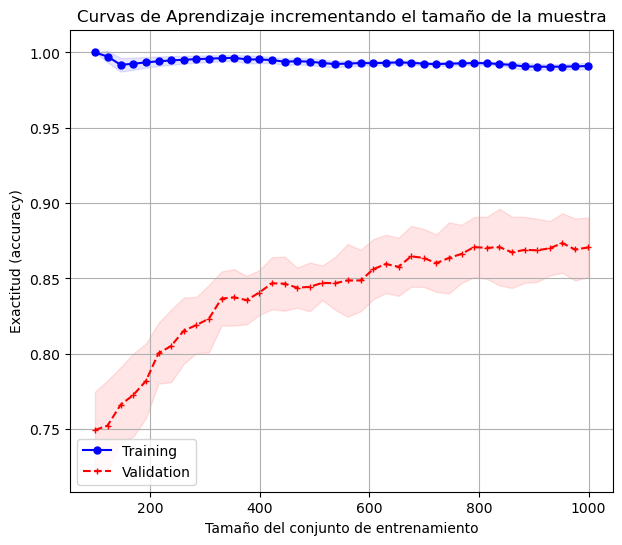

In [48]:
from sklearn.model_selection import learning_curve, RepeatedStratifiedKFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Function to create and evaluate the model
def mi_ModeloYCurvas(Xin, ytv):
    # Replace Logistic Regression with XGBoost
    modelo = xgb.XGBClassifier(random_state=1)

    # Define the pipeline with XGBoost
    mi_pipe = Pipeline([('modelo', modelo)])

    # Your existing RepeatedStratifiedKFold and other settings
    mi_kfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=7)
    delta_train_sz = np.linspace(0.1, 1.0, 40)

    # Generate learning curve data
    tr_sizes, tr_scores, val_scores = learning_curve(estimator=mi_pipe,    
                                                     X=Xin,
                                                     y=ytv,
                                                     cv=mi_kfold,
                                                     train_sizes=delta_train_sz,
                                                     random_state=11)

    # Plot the learning curves
    mi_LearningCurvePlot(tr_sizes, tr_scores, val_scores)

# Assuming Xtv and ytv are your features and target variable
# Example call to your function
print('Curvas de aprendizaje del modelo XGBoost:')
mi_ModeloYCurvas(X_train, y_train)

Curvas de aprendizaje del modelo XGBoost:


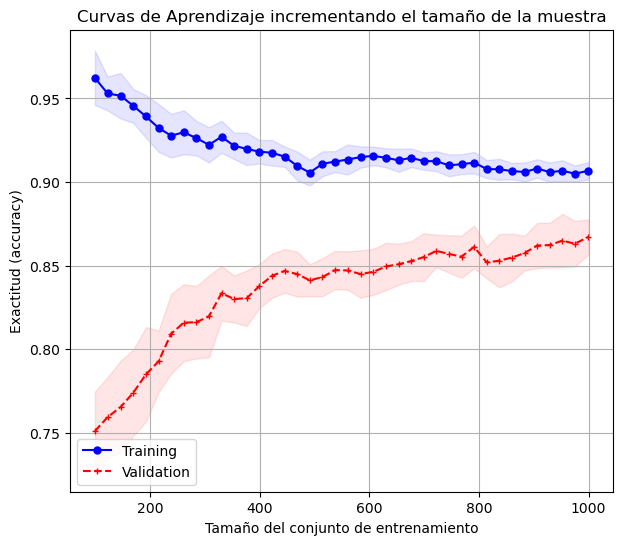

In [49]:
from sklearn.model_selection import learning_curve, RepeatedStratifiedKFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Function to create and evaluate the model
def mi_ModeloYCurvas(Xin, ytv):
    # Replace Logistic Regression with XGBoost
    modelo = xgb.XGBClassifier(
        max_depth=3,                 # Lower max_depth
        learning_rate=0.1,           # Lower learning_rate
        n_estimators=100,            # Number of trees
        alpha=1,                     # L1 regularization
        # lambda=1,                    # L2 regularization
        gamma=0.1,                   # Minimum loss reduction required to make a further partition
        min_child_weight=1,          # Minimum sum of instance weight(hessian) needed in a child
        subsample=0.8,               # Subsample ratio of the training instance
        colsample_bytree=0.8,        # Subsample ratio of columns when constructing each tree
        random_state=1,
        n_jobs=-1
    )

    # Define the pipeline with XGBoost
    mi_pipe = Pipeline([('modelo', modelo)])

    # Your existing RepeatedStratifiedKFold and other settings
    mi_kfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=7)
    delta_train_sz = np.linspace(0.1, 1.0, 40)

    # Generate learning curve data
    tr_sizes, tr_scores, val_scores = learning_curve(estimator=mi_pipe,    
                                                     X=Xin,
                                                     y=ytv,
                                                     cv=mi_kfold,
                                                     train_sizes=delta_train_sz,
                                                     random_state=11)

    # Plot the learning curves
    mi_LearningCurvePlot(tr_sizes, tr_scores, val_scores)

# Assuming Xtv and ytv are your features and target variable
# Example call to your function
print('Curvas de aprendizaje del modelo XGBoost:')
mi_ModeloYCurvas(X_train, y_train)

Curvas de aprendizaje del modelo XGBoost:


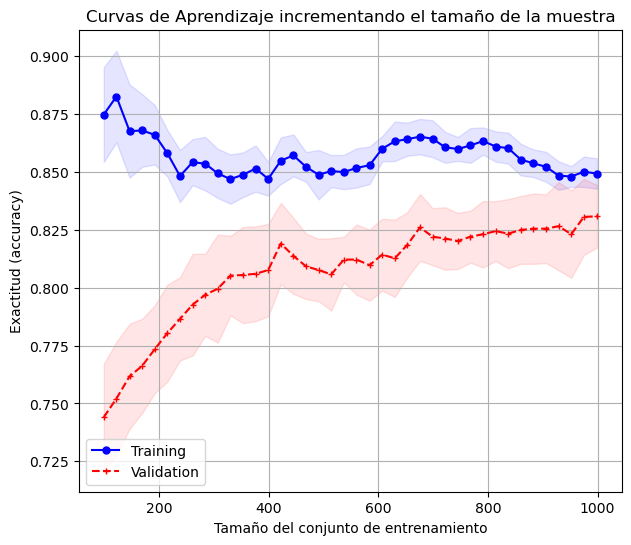

In [50]:
from sklearn.model_selection import learning_curve, RepeatedStratifiedKFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Function to create and evaluate the model
def mi_ModeloYCurvas(Xin, ytv):
    # Replace Logistic Regression with XGBoost
    modelo = xgb.XGBClassifier(
        max_depth=2,                 # Lower max_depth
        learning_rate=0.1,           # Lower learning_rate
        n_estimators=50,            # Number of trees
        alpha=1,                     # L1 regularization
                          # L2 regularization
        gamma=0.1,                   # Minimum loss reduction required to make a further partition
        min_child_weight=1,          # Minimum sum of instance weight(hessian) needed in a child
        subsample=0.8,               # Subsample ratio of the training instance
        colsample_bytree=0.8,        # Subsample ratio of columns when constructing each tree
        random_state=1,
        n_jobs=-1
    )

    # Define the pipeline with XGBoost
    mi_pipe = Pipeline([('modelo', modelo)])

    # Your existing RepeatedStratifiedKFold and other settings
    mi_kfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=7)
    delta_train_sz = np.linspace(0.1, 1.0, 40)

    # Generate learning curve data
    tr_sizes, tr_scores, val_scores = learning_curve(estimator=mi_pipe,    
                                                     X=Xin,
                                                     y=ytv,
                                                     cv=mi_kfold,
                                                     train_sizes=delta_train_sz,
                                                     random_state=11)

    # Plot the learning curves
    mi_LearningCurvePlot(tr_sizes, tr_scores, val_scores)

# Assuming Xtv and ytv are your features and target variable
# Example call to your function
print('Curvas de aprendizaje del modelo XGBoost:')
mi_ModeloYCurvas(X_train, y_train)